In [13]:
import torch
torch.cuda.is_available()

True

In [2]:
!pip install transformers datasets scikit-learn

In [3]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [4]:
dataset = load_dataset("imdb")
dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [16]:
if 'text' in tokenized_datasets['train'].column_names:
    tokenized_datasets = tokenized_datasets.remove_columns(["text"])

if 'label' in tokenized_datasets['train'].column_names:
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

tokenized_datasets.set_format("torch")

In [17]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [19]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [23]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"].shuffle(seed=42).select(range(5000)),
    eval_dataset=tokenized_datasets["test"].shuffle(seed=42).select(range(2000)),
    compute_metrics=compute_metrics
)


In [25]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.245875,0.897500,0.900437,0.875354,0.927000
2,0.280648,0.295748,0.899000,0.901271,0.881453,0.922000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=626, training_loss=0.252409700387583, metrics={'train_runtime': 594.9636, 'train_samples_per_second': 16.808, 'train_steps_per_second': 1.052, 'total_flos': 1315555276800000.0, 'train_loss': 0.252409700387583, 'epoch': 2.0})

In [26]:
results = trainer.evaluate()
results


{'eval_loss': 0.24586303532123566,
 'eval_accuracy': 0.897,
 'eval_f1': 0.8999028182701652,
 'eval_precision': 0.8752362948960303,
 'eval_recall': 0.926,
 'eval_runtime': 34.5441,
 'eval_samples_per_second': 57.897,
 'eval_steps_per_second': 3.619,
 'epoch': 2.0}

In [27]:
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True).to(device)
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits)
    return "Positive" if prediction == 1 else "Negative"

predict("The movie was absolutely fantastic!")
predict("This was the worst film I have ever seen.")


'Negative'

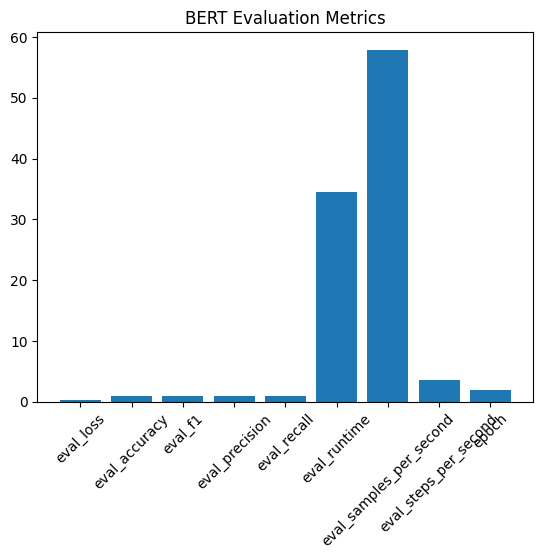

In [28]:
metrics = results

plt.figure()
plt.bar(metrics.keys(), metrics.values())
plt.xticks(rotation=45)
plt.title("BERT Evaluation Metrics")
plt.show()
